In [1]:
from data import TwitterP
import numpy as np
from tqdm import trange

In [2]:
trainT, validationT, testT = TwitterP.load_data()

In [3]:
df=trainT.append(validationT)
df=df.append(testT)

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16988\2501083903.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=trainT.append(validationT)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_16988\2501083903.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append(testT)


In [4]:
Negative_tweets=[]
Positive_tweets=[]
n_private=0
for i in trange(1,len(df)):
    timeline, retval = TwitterP.get_username_profile(df['username'].iloc[i])
    if(retval == 0):
        continue
    if df["Positive"][i]==1:
        if (timeline.empty):
            n_private+=1
        else:
            Positive_tweets=np.append(Positive_tweets,timeline.tweet)
    if df["Negative"][i]==1:
        if (timeline.empty):
            n_private+=1
        else:
            Negative_tweets=np.append(Negative_tweets,timeline.tweet)

100%|█████████████████████████████████████████████████████████████████████████████| 2330/2330 [00:17<00:00, 136.30it/s]


In [5]:
PL = [1] * len(Positive_tweets) 
NL = [0] * len(Negative_tweets) 

In [6]:
len(Positive_tweets), len(Negative_tweets) 

(27990, 15807)

In [7]:
x=np.append(Positive_tweets[10001:15000],Negative_tweets[10001:15000])
y=np.append(PL[10001:15000],NL[10001:15000])

In [8]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [9]:
import pandas as pd 
d = {'Tweet':x,'label':y}
df = pd.DataFrame(d)

In [10]:
df.to_csv('test_data.csv', index=False)

In [11]:
x=np.append(Positive_tweets[0:10000],Negative_tweets[0:10000])
y=np.append(PL[0:10000],NL[0:10000])

In [12]:
import os
import numpy as np

# using predefined embeddings from txt file
embeddings_index = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [13]:
import sys

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

In [14]:
# Setting some parameters

MAX_SEQUENCE_LENGTH = 200 # determines how many words of every tweet will be processed
# if the tweet length is smaller than this, the tweet will be padded until it has a length equivalent to this

MAX_NUM_WORDS = 70000 # how many unique words in the training text to be tokenised
EMBEDDING_DIM = 100 # number of dimensions in the word embeddings
TRAINING_SPLIT = 0.8 # proportion of data to be used to training

In [15]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
seq_lengths = [len(x) for x in sequences]

In [17]:
MAX_SEQUENCE_LENGTH = max(seq_lengths)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [18]:
labels = to_categorical(np.asarray(y))

In [19]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# before splitting
num_training_samples = int(TRAINING_SPLIT * data.shape[0])

In [20]:
x_train = data[:num_training_samples]
y_train = labels[:num_training_samples]
x_val = data[num_training_samples:]
y_val = labels[num_training_samples:]

In [21]:
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# we set trainable = False  to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [22]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(256))(embedded_sequences)
y = Dropout(0.5)(x)

preds = Dense(labels.shape[1], activation='softmax')(y)
model = Model(sequence_input, preds)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 74)]              0         
                                                                 
 embedding (Embedding)       (None, 74, 100)           5386000   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              731136    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 6,118,162
Trainable params: 732,162
Non-trainable params: 5,386,000
_____________________________________________

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(patience=4, monitor='acc')
callbacks = [earlystopping, checkpoint]

model.fit(x_train, y_train,
          batch_size=32,
          epochs=25,
          validation_data=(x_val, y_val),
          callbacks=callbacks,
          verbose=2)

model.load_weights("best_weights.hdf5")

Epoch 1/25

Epoch 1: val_acc improved from -inf to 0.50850, saving model to best_weights.hdf5
500/500 - 156s - loss: 0.6985 - acc: 0.5272 - val_loss: 0.8209 - val_acc: 0.5085 - 156s/epoch - 312ms/step
Epoch 2/25

Epoch 2: val_acc improved from 0.50850 to 0.57325, saving model to best_weights.hdf5
500/500 - 140s - loss: 0.6768 - acc: 0.5587 - val_loss: 0.6655 - val_acc: 0.5732 - 140s/epoch - 280ms/step
Epoch 3/25

Epoch 3: val_acc improved from 0.57325 to 0.58850, saving model to best_weights.hdf5
500/500 - 138s - loss: 0.6539 - acc: 0.5939 - val_loss: 0.6452 - val_acc: 0.5885 - 138s/epoch - 277ms/step
Epoch 4/25

Epoch 4: val_acc did not improve from 0.58850
500/500 - 137s - loss: 0.6530 - acc: 0.5974 - val_loss: 0.6528 - val_acc: 0.5857 - 137s/epoch - 273ms/step
Epoch 5/25

Epoch 5: val_acc improved from 0.58850 to 0.59825, saving model to best_weights.hdf5
500/500 - 143s - loss: 0.6281 - acc: 0.6299 - val_loss: 0.6449 - val_acc: 0.5982 - 143s/epoch - 287ms/step
Epoch 6/25

Epoch 6: v

In [53]:
def predict_tweet(text_to_predict):
    classes_index = ['Depressed', 'Not depressed']
    test_sequence = tokenizer.texts_to_sequences([text_to_predict])
    test_data = pad_sequences(test_sequence, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(test_data)
    prediction = np.argmax(predictions)
    #print(prediction)
    #print("The person who tweeted this is {}\n".format(classes_index[prediction]))
    return prediction

In [27]:
predict_tweet("sad")

1/1 [==============================] - 1s 1s/step
0
The person who tweeted this is Depressed



In [28]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras   
from data import Images_load

In [29]:
train, validation, test = Images_load.load_data()

100%|█████████████████████████████████████████████████████████████████████████████| 1736/1736 [00:01<00:00, 951.86it/s]


In [30]:
features, labels = train.features, train.labels
featuresV, labelsV = validation.features, validation.labels
featuresT, labelsT = test.features, test.labels

def stack_uneven(arrays, fill_value=0.):
    sizes = [a.shape for a in arrays]
    max_sizes = np.max(list(zip(*sizes)), -1)
    # The resultant array has stacked on the first dimension
    result = np.full((len(arrays),) + tuple(max_sizes), fill_value)
    for i, a in enumerate(arrays):
      # The shape of this array `a`, turned into slices
      slices = tuple(slice(0,s) for s in sizes[i])
      # Overwrite a block slice of `result` with this array `a`
      result[i][slices] = a
    return result

x_train = stack_uneven(features)
y_train = stack_uneven(labels)
y_test = stack_uneven(labelsT)
y_val = stack_uneven(labelsV)
x_test = stack_uneven(featuresT)

xtest = []

x_test = np.delete(x_test, 3, axis=3)

x_test /= 225
x_train /= 225

In [31]:
(unique, counts) = np.unique(y_train, return_counts=True)

frequencies = np.asarray((unique, counts)).T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

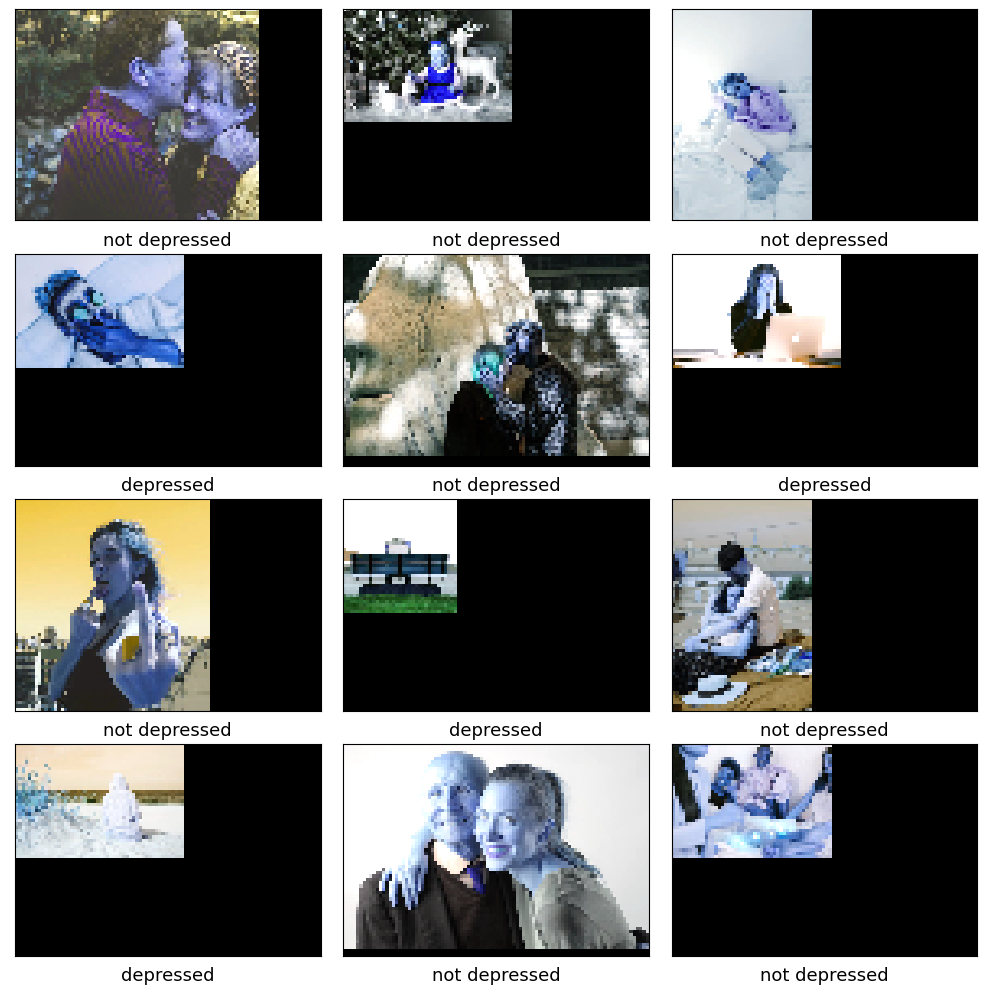

In [32]:
class_types = ['not depressed', 'depressed']
plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    if(y_train[i][0] == 0.0):
        index = 0
    else:
        index = 1
    plt.xlabel(class_types[index], fontsize=13)
plt.tight_layout()    

In [33]:
train_lab_categorical = tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(
    y_test, num_classes=2, dtype='uint8')

In [34]:
from sklearn.model_selection import train_test_split 



train_im, valid_im, train_lab, valid_lab = train_test_split(x_train, y_train.astype(int), test_size=0.20, 
                                                            stratify=y_train.astype(int), 
                                                            random_state=40, shuffle = True)

In [35]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [36]:
batch_size = 64 # try several values

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size)

In [37]:
def res_identity(x, filters): 
  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  # x = Activation(activations.relu)(x)

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [38]:
def res_conv(x, s, filters):
  '''
  here the input size changes, when it goes via conv blocks
  so the skip connection uses a projection (conv layer) matrix
  ''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

In [39]:
def resnet50():

  input_im = Input(shape=(train_im.shape[1], train_im.shape[2], train_im.shape[3])) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  x = Dense(len(class_types), activation='softmax', kernel_initializer='he_normal')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [40]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop 

In [41]:
resnet50_model = resnet50()

In [42]:
resnet50_model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65, 94, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 71, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 33, 47, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 33, 47, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

 conv2d_10 (Conv2D)             (None, 16, 23, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 23, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 16, 23, 256)  0           ['batch_normalization_10[0][0]', 
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 16, 23, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_11

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 8, 12, 512)   0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 8, 12, 128)   65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 8, 12, 128)  512         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 8, 12, 128)   0           ['batch_normalization_21[0][0]'] 
          

 batch_normalization_31 (BatchN  (None, 4, 6, 256)   1024        ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 4, 6, 256)    0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 4, 6, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 4, 6, 256)   1024        ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_42 (Conv2D)             (None, 4, 6, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 4, 6, 1024)  4096        ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_12 (Add)                   (None, 4, 6, 1024)   0           ['batch_normalization_42[0][0]', 
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 4, 6, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 2, 3, 2048)   0           ['batch_normalization_52[0][0]', 
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 2, 3, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 2, 2048)  0           ['activation_48[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_1 (

In [43]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

steps=train_im.shape[0]/64
val_steps=valid_im.shape[0]/64

In [44]:
batch_size=batch_size # test with 64, 128, 256
resnet_train = resnet50_model.fit(train_set_conv, 
                                  epochs=15, 
                                  steps_per_epoch=2, 
                                  validation_steps=1, 
                                  validation_data=valid_set_conv, 
                                  callbacks=[lrdecay])

Epoch 1/15
2/2 [==============================] - 22s 7s/step - loss: 22.5567 - acc: 0.4922 - val_loss: 18.7640 - val_acc: 0.5000 - lr: 0.0010
Epoch 2/15
2/2 [==============================] - 11s 6s/step - loss: 24.2014 - acc: 0.5703 - val_loss: 18.7404 - val_acc: 0.6875 - lr: 0.0010
Epoch 3/15
2/2 [==============================] - 12s 7s/step - loss: 20.1995 - acc: 0.6641 - val_loss: 18.7460 - val_acc: 0.7344 - lr: 0.0010
Epoch 4/15
2/2 [==============================] - 12s 6s/step - loss: 19.1383 - acc: 0.7656 - val_loss: 18.9458 - val_acc: 0.5625 - lr: 0.0010
Epoch 5/15
2/2 [==============================] - 10s 5s/step - loss: 18.9179 - acc: 0.8125 - val_loss: 19.0639 - val_acc: 0.5312 - lr: 0.0010
Epoch 6/15
2/2 [==============================] - 10s 6s/step - loss: 18.9970 - acc: 0.7812 - val_loss: 19.0887 - val_acc: 0.5312 - lr: 0.0010
Epoch 7/15
2/2 [==============================] - 11s 6s/step - loss: 18.8067 - acc: 0.7891 - val_loss: 19.1505 - val_acc: 0.4062 - lr: 0.0010

In [45]:
 pred_class_resnet50 = resnet50_model.predict(x_test)

30/30 [==============================] - 12s 339ms/step


In [61]:
#print(pred_class_resnet50[0])
img_pred = []
for i in range(0, 12):
    if(pred_class_resnet50[0][0]<=0.5):
        img_pred.append(0)
    else:
        img_pred.append(1)

In [49]:
test_imgs = []
count=0
for x in x_test:
    if(count<12):
        test_imgs.append(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


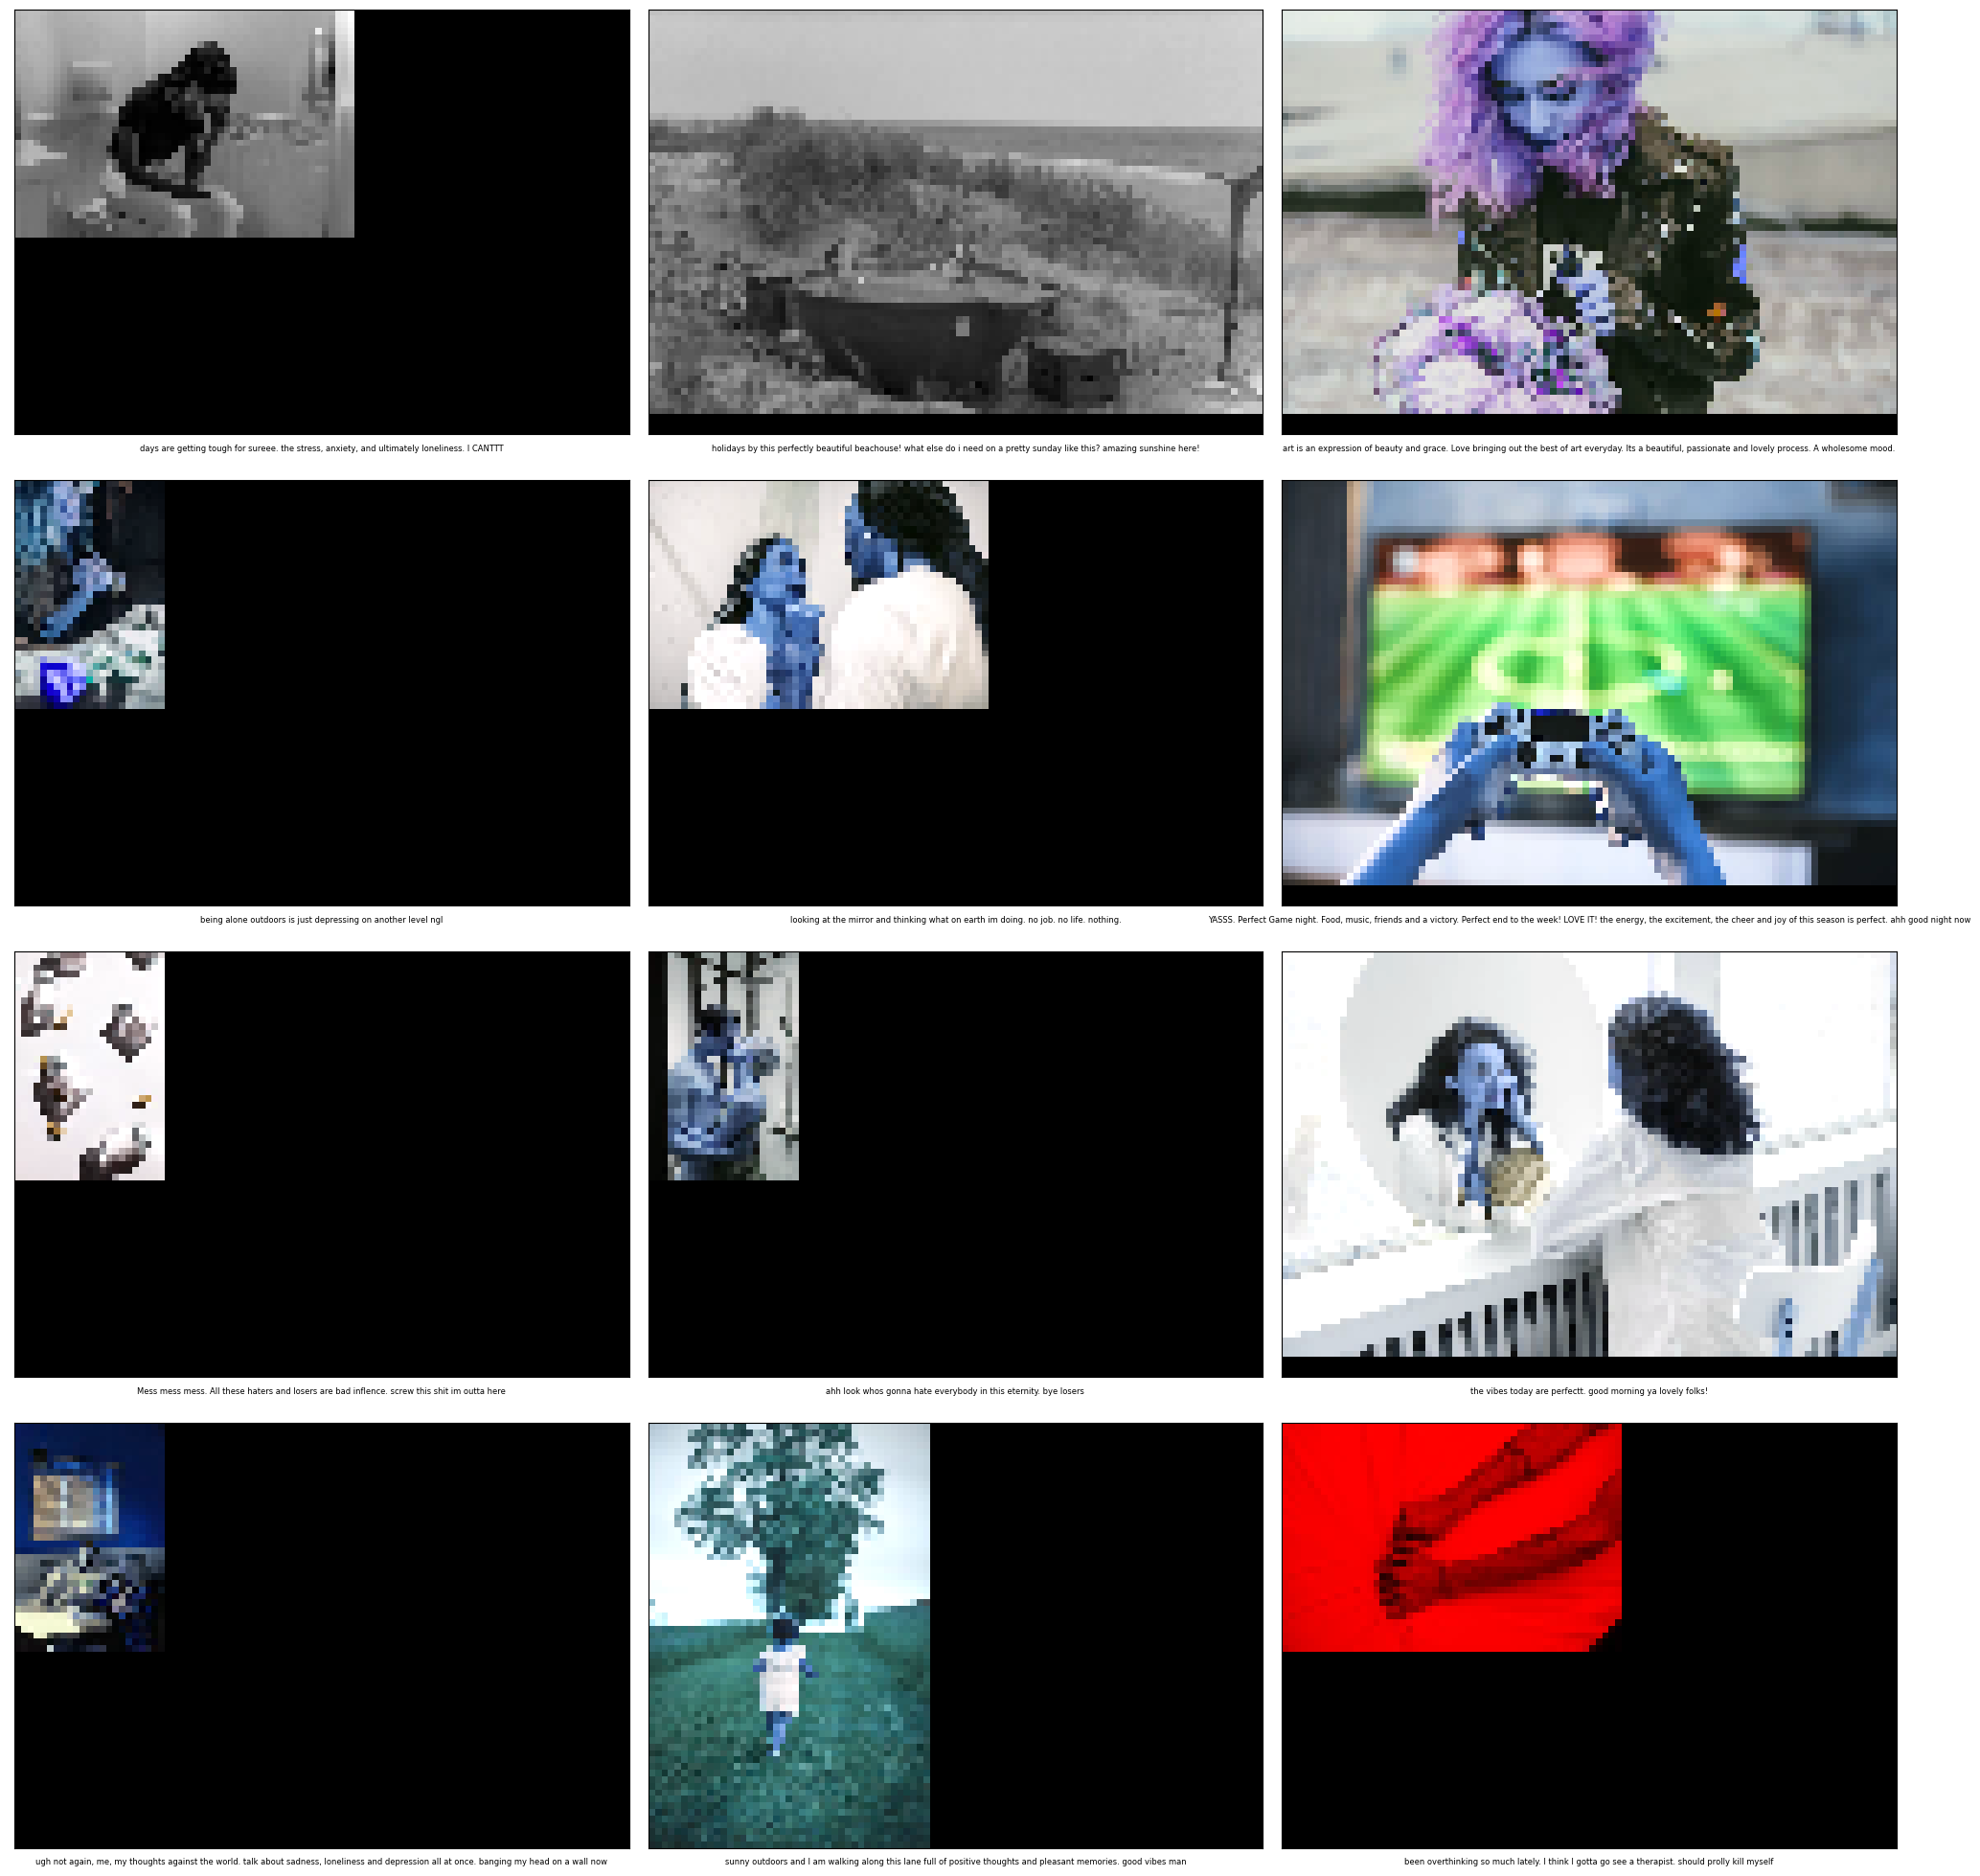

In [153]:
test_text = ['days are getting tough for sureee. the stress, anxiety, and ultimately loneliness. I CANTTT',
            'holidays by this perfectly beautiful beachouse! what else do i need on a pretty sunday like this? amazing sunshine here!',
            'art is an expression of beauty and grace. Love bringing out the best of art everyday. Its a beautiful, passionate and lovely process. A wholesome mood.',
            'being alone outdoors is just depressing on another level ngl',
            'looking at the mirror and thinking what on earth im doing. no job. no life. nothing.',
            'YASSS. Perfect Game night. Food, music, friends and a victory. Perfect end to the week! LOVE IT! the energy, the excitement, the cheer and joy of this season is perfect. ahh good night now',
            'Mess mess mess. All these haters and losers are bad inflence. screw this shit im outta here',
            'ahh look whos gonna hate everybody in this eternity. bye losers',
            'the vibes today are perfectt. good morning ya lovely folks!',
            'ugh not again, me, my thoughts against the world. talk about sadness, loneliness and depression all at once. banging my head on a wall now',
            'sunny outdoors and I am walking along this lane full of positive thoughts and pleasant memories. good vibes man',
            'been overthinking so much lately. I think I gotta go see a therapist. should prolly kill myself']

test_result = ['Depressed', 'Not depressed', 'Not depressed', 'Depressed', 'Depressed', 'Not depressed', 'Depressed', 'Depressed', 'Not depressed',
              'Depressed', 'Not depressed', 'Depressed']

class_types = ['not depressed', 'depressed']
plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_test[i], cmap='gray')
    if(y_test[i][0] == 0.0):
        index = 0
    else:
        index = 1
    plt.xlabel(test_text[i], fontsize=6)
    plt.tight_layout() 

In [145]:
res = []
for prompt in test_text:
    res.append(predict_tweet(prompt))

1/1 [==============================] - 0s 37ms/step


In [146]:
import math

#print(res)
#print(img_pred)
final_result = []
final_result1 = []

for i in range(0,12):
    if(res[i] == img_pred[i]):
        result = img_pred[i]
    else:
        result = math.ceil((res[i]+img_pred[i])/2)
        result = res[i]
    final_result.append(result)

In [147]:
final_result1 = []
for r in final_result:
    if(r == 0):
        final_result1.append("Depressed")
    else:
        final_result1.append("Not depressed")

print("CLASSIFICATION RESULT: ", final_result1)
print()
print("ACTUAL RESULT: ", test_result)

CLASSIFICATION RESULT:  ['Depressed', 'Not depressed', 'Depressed', 'Depressed', 'Depressed', 'Depressed', 'Not depressed', 'Depressed', 'Not depressed', 'Depressed', 'Not depressed', 'Depressed']

ACTUAL RESULT:  ['Depressed', 'Not depressed', 'Not depressed', 'Depressed', 'Depressed', 'Not depressed', 'Depressed', 'Depressed', 'Not depressed', 'Depressed', 'Not depressed', 'Depressed']


In [148]:
correct_count=0
total_count = 12

for i in range(0,12):
    if(final_result1[i] == test_result[i]):
        correct_count += 1
accuracy = 100*(correct_count/total_count)
print("Accuracy: ", accuracy, "%")

Accuracy:  75.0 %
